In [1]:
# lancer le notebook eda_business avant de lancer celui-ci

In [2]:

# Auto-reload pour développement interactif
%load_ext autoreload
%autoreload 2

# Imports nécessaires pour la visualisation
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

















In [3]:
# --- Configuration des chemins ---
BASE_DIR = Path().resolve().parent.parent
DATA_DIR = BASE_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
VISUALS_DIR = PROCESSED_DIR / "visuals"
VISUALS_DIR.mkdir(exist_ok=True) # Créer le dossier pour sauvegarder les graphiques



In [4]:
# --- Configuration du style des graphiques ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (18, 12)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
PALETTE_COULEURS = ['#45B7D1', '#FF6B6B', '#4ECDC4', '#FECA57', '#6C5CE7', '#FF7675']



In [5]:
# --- Chargement des données des notebooks précédents ---
print("\nChargement des données pré-calculées...")
try:
    with open(PROCESSED_DIR / 'preprocessing_variables.pkl', 'rb') as f:
        preprocessing_vars = pickle.load(f)
        df_clean_dedup = preprocessing_vars['df_clean_dedup']
    print("   - Données du preprocessing chargées.")

    with open(PROCESSED_DIR / 'eda_business_results.pkl', 'rb') as f:
        eda_results = pickle.load(f)
        source_analysis = eda_results['source_analysis']
        temporal_results = eda_results['temporal_results']
        semantic_results = eda_results['semantic_results']
        df_quality = eda_results['df_quality']
        premium_articles = eda_results['premium_articles']
        anomalies = eda_results['anomalies']
    print("   - Résultats de l'analyse EDA chargés.")
    print("Chargement terminé avec succès.")

except FileNotFoundError as e:
    print(f"ERREUR: Fichier de données non trouvé : {e.filename}")
    print("Veuillez exécuter les notebooks 'preprocessing_advanced.ipynb' et 'eda_business.ipynb' avant de lancer celui-ci.")
    exit(1)




Chargement des données pré-calculées...
   - Données du preprocessing chargées.
   - Résultats de l'analyse EDA chargés.
Chargement terminé avec succès.



Création du dashboard principal (vue d'ensemble)...


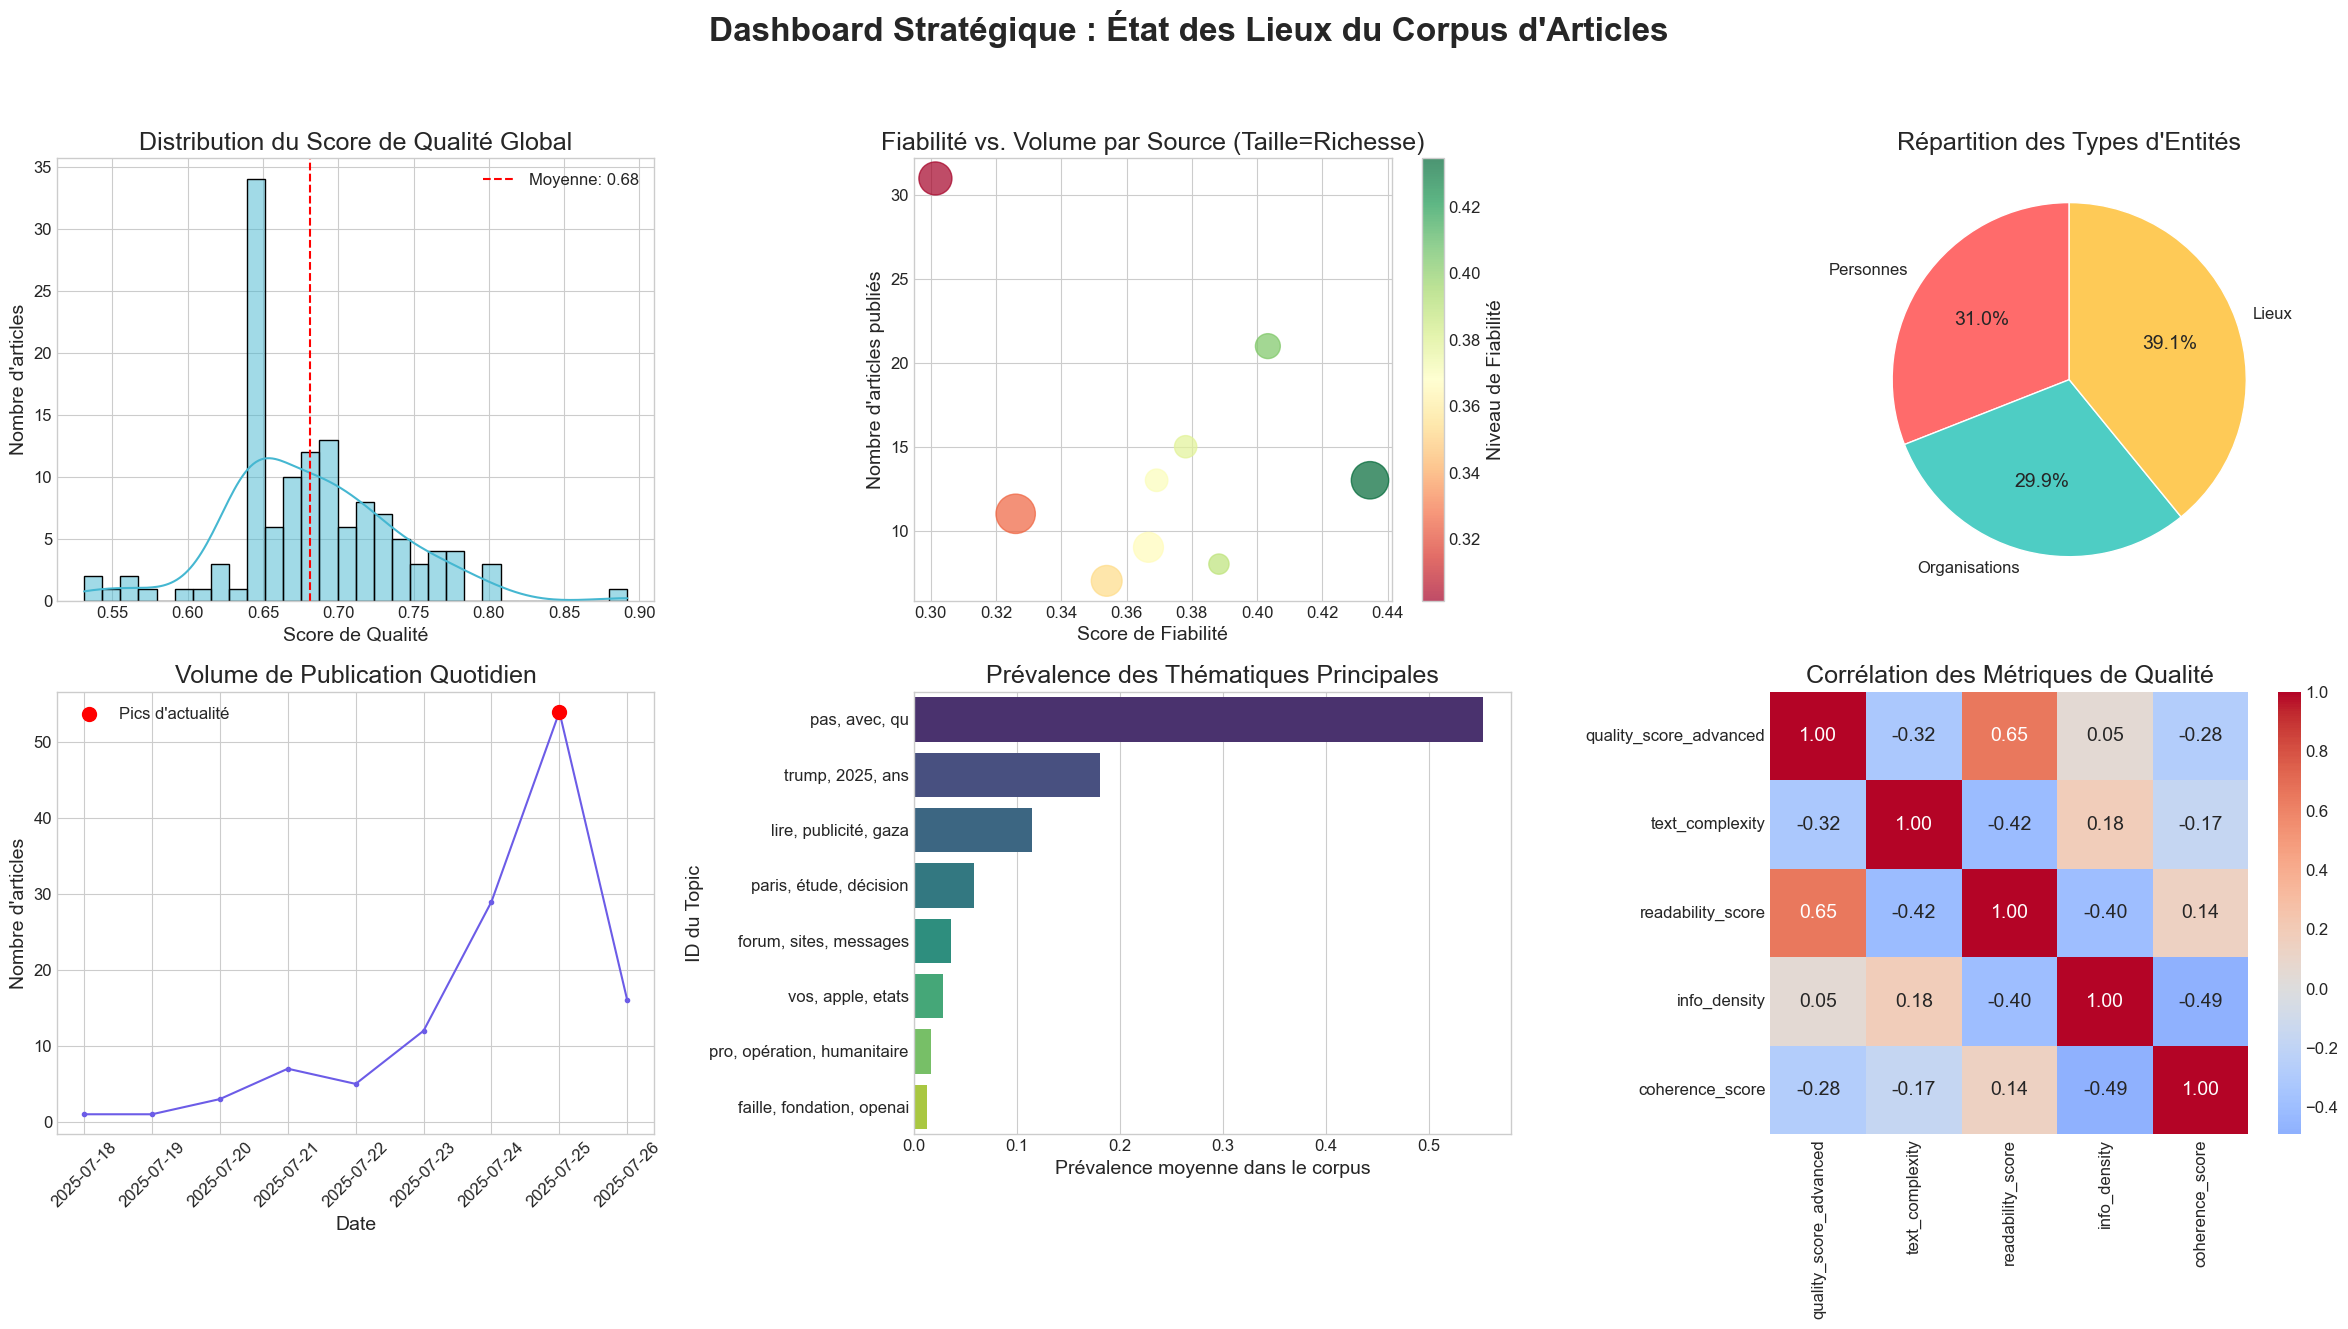

In [24]:

print("\nCréation du dashboard principal (vue d'ensemble)...")

fig, axes = plt.subplots(2, 3, figsize=(24, 14))
fig.suptitle("Dashboard Stratégique : État des Lieux du Corpus d'Articles", fontsize=24, fontweight='bold')

# --- Graphique 2.1: Distribution du Score de Qualité ---
sns.histplot(df_quality['quality_score_advanced'], bins=30, kde=True, ax=axes[0, 0], color=PALETTE_COULEURS[0])
mean_quality = df_quality['quality_score_advanced'].mean()
axes[0, 0].axvline(mean_quality, color='red', linestyle='--', label=f'Moyenne: {mean_quality:.2f}')
axes[0, 0].set_title('Distribution du Score de Qualité Global')
axes[0, 0].set_xlabel('Score de Qualité')
axes[0, 0].set_ylabel("Nombre d'articles")
axes[0, 0].legend()

# --- Graphique 2.2: Fiabilité et Volume des Sources ---
top_sources_plot = source_analysis.head(15)
scatter = axes[0, 1].scatter(
    top_sources_plot['reliability_score'],
    top_sources_plot['quality_score_advanced_count'],
    s=top_sources_plot['entities_total_mean']*20,
    c=top_sources_plot['reliability_score'],
    cmap='RdYlGn',
    alpha=0.7
)
axes[0, 1].set_title('Fiabilité vs. Volume par Source (Taille=Richesse)')
axes[0, 1].set_xlabel('Score de Fiabilité')
axes[0, 1].set_ylabel("Nombre d'articles publiés")
fig.colorbar(scatter, ax=axes[0, 1], label='Niveau de Fiabilité')

# --- Graphique 2.3: Distribution des Types d'Entités ---
entity_counts = [
    df_clean_dedup['persons_count'].sum(),
    df_clean_dedup['organizations_count'].sum(),
    df_clean_dedup['locations_count'].sum()
]
entity_labels = ['Personnes', 'Organisations', 'Lieux']
axes[0, 2].pie(entity_counts, labels=entity_labels, autopct='%1.1f%%',
               colors=PALETTE_COULEURS[1:4], startangle=90, wedgeprops={'edgecolor': 'white'})
axes[0, 2].set_title("Répartition des Types d'Entités")

# --- Graphique 2.4: Évolution Temporelle des Publications ---
daily_counts = temporal_results['daily_pattern']
if len(daily_counts) > 1:
    daily_counts.plot(ax=axes[1, 0], marker='.', linestyle='-', color=PALETTE_COULEURS[4])
    # Mettre en évidence les pics d'actualité
    peak_days = temporal_results['peak_days']
    if not peak_days.empty:
        peak_dates = pd.to_datetime(peak_days.index)
        axes[1, 0].scatter(peak_dates, peak_days.values, color='red', s=100, zorder=5, label='Pics d\'actualité')
    axes[1, 0].legend()
axes[1, 0].set_title('Volume de Publication Quotidien')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel("Nombre d'articles")
axes[1, 0].tick_params(axis='x', rotation=45)


# --- Graphique 2.5: Prévalence des Thématiques (Topics) ---
if semantic_results:
    topic_distribution = semantic_results['doc_topics'].mean(axis=0)
    topic_df = pd.DataFrame({
        'prevalence': topic_distribution,
        'words': [', '.join(t['words'][:3]) for t in semantic_results['topics']]
    }).sort_values('prevalence', ascending=False)
    
    sns.barplot(x='prevalence', y=topic_df.index.astype(str), data=topic_df, ax=axes[1, 1],
                orient='h', palette='viridis')
    axes[1, 1].set_title('Prévalence des Thématiques Principales')
    axes[1, 1].set_xlabel('Prévalence moyenne dans le corpus')
    axes[1, 1].set_ylabel('ID du Topic')
    axes[1, 1].set_yticklabels(topic_df['words'])
else:
    axes[1, 1].text(0.5, 0.5, "Analyse sémantique non disponible", ha='center', va='center')


# --- Graphique 2.6: Matrice de Corrélation des Métriques Clés ---
quality_metrics_corr = df_quality[[
    'quality_score_advanced', 'text_complexity', 'readability_score',
    'info_density', 'coherence_score'
]].corr()
sns.heatmap(quality_metrics_corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1, 2], center=0)
axes[1, 2].set_title('Corrélation des Métriques de Qualité')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(VISUALS_DIR / 'dashboard_principal.png', dpi=300)
plt.show()


In [13]:
# --- Interprétation du Dashboard Principal ---
print("\n--- Interprétation du Dashboard Stratégique ---")
print(f"Score de qualité moyen : {mean_quality:.2f}. Une distribution normale est saine. Un pic à gauche indique un problème de qualité général.")
print(f"Analyse des sources : L'idéal est d'avoir des sources à la fois fiables (axe X élevé) et prolifiques (axe Y élevé). Celles en bas à gauche sont à surveiller.")
print("La répartition des entités montre le focus du corpus (ex: plus d'organisations pour un focus économique).")
print("Les pics temporels correspondent souvent à des événements majeurs et méritent une analyse approfondie des sujets traités ces jours-là.")
print("La prévalence des topics indique les thématiques dominantes. Un bon équilibre est souvent souhaitable.")



--- Interprétation du Dashboard Stratégique ---
Score de qualité moyen : 0.68. Une distribution normale est saine. Un pic à gauche indique un problème de qualité général.
Analyse des sources : L'idéal est d'avoir des sources à la fois fiables (axe X élevé) et prolifiques (axe Y élevé). Celles en bas à gauche sont à surveiller.
La répartition des entités montre le focus du corpus (ex: plus d'organisations pour un focus économique).
Les pics temporels correspondent souvent à des événements majeurs et méritent une analyse approfondie des sujets traités ces jours-là.
La prévalence des topics indique les thématiques dominantes. Un bon équilibre est souvent souhaitable.




Lancement de l'analyse détaillée de la qualité des contenus...


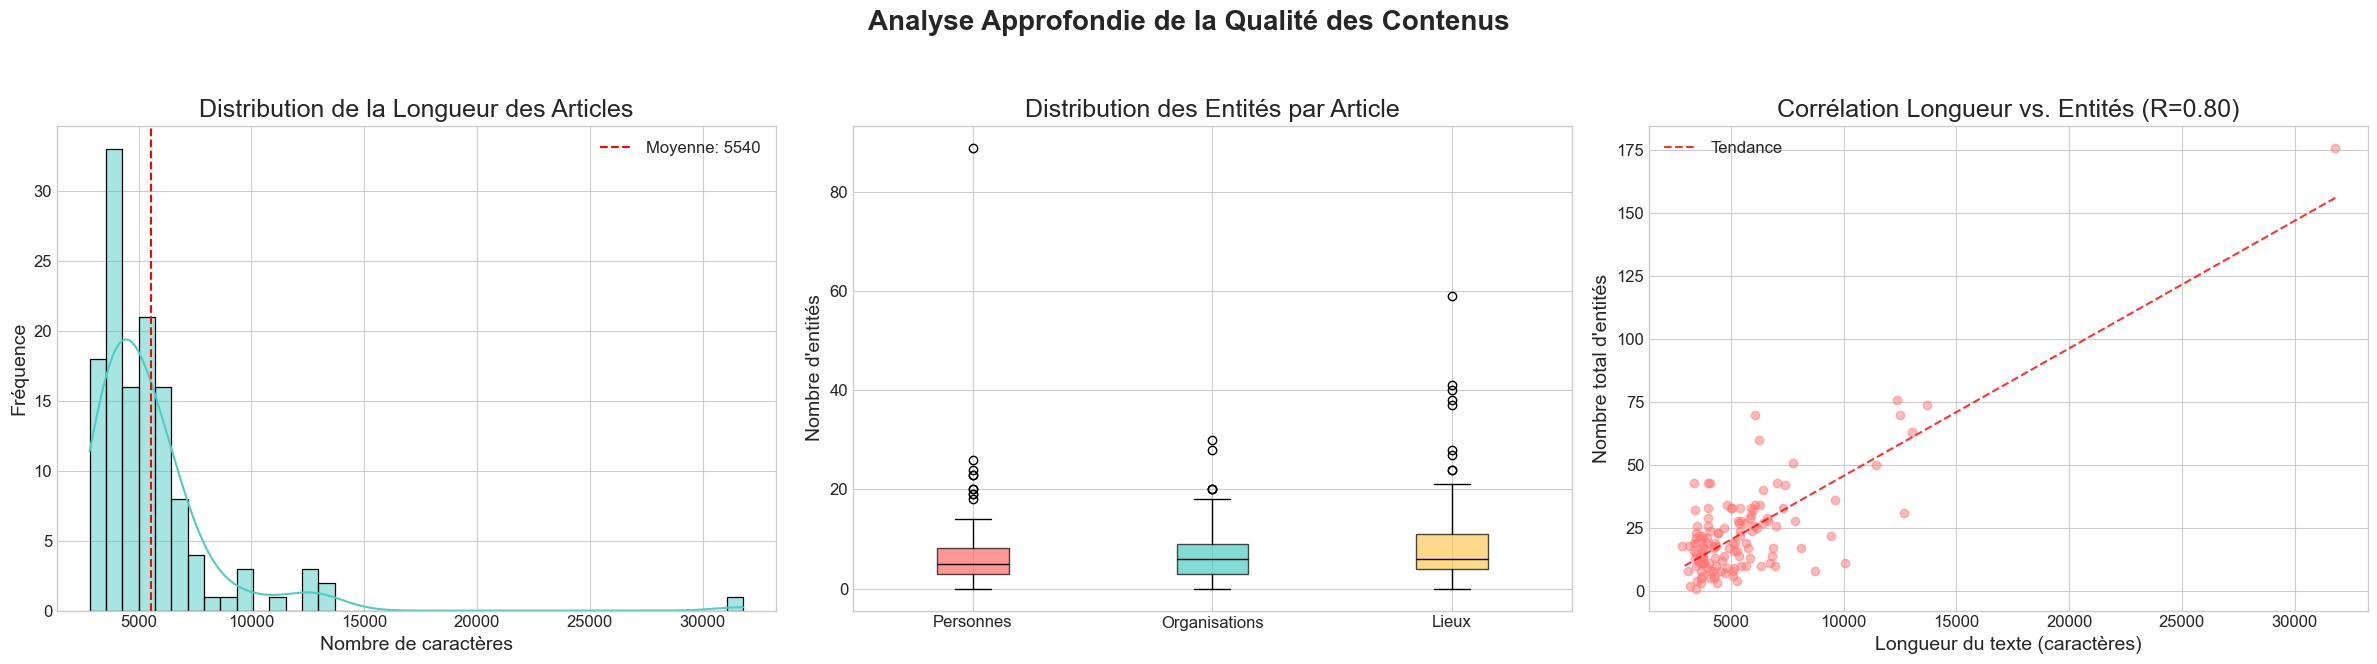

In [25]:
print("\n\nLancement de l'analyse détaillée de la qualité des contenus...")
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle("Analyse Approfondie de la Qualité des Contenus", fontsize=20, fontweight='bold')

# --- Graphique 3.1: Distribution de la Longueur des Textes ---
text_lengths = df_quality['text_cleaned'].str.len()
sns.histplot(text_lengths, bins=40, ax=axes[0], color=PALETTE_COULEURS[2], kde=True)
axes[0].axvline(text_lengths.mean(), color='red', linestyle='--', label=f'Moyenne: {text_lengths.mean():.0f}')
axes[0].set_title('Distribution de la Longueur des Articles')
axes[0].set_xlabel('Nombre de caractères')
axes[0].set_ylabel('Fréquence')
axes[0].legend()

# --- Graphique 3.2: Richesse en Entités par Article ---
entity_data = [
    df_quality['persons_count'],
    df_quality['organizations_count'],
    df_quality['locations_count']
]
bp = axes[1].boxplot(entity_data, labels=['Personnes', 'Organisations', 'Lieux'], patch_artist=True,
                     medianprops={'color': 'black'})
for patch, color in zip(bp['boxes'], PALETTE_COULEURS[1:4]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_title('Distribution des Entités par Article')
axes[1].set_ylabel("Nombre d'entités")

# --- Graphique 3.3: Corrélation Longueur vs. Richesse Informationnelle ---
axes[2].scatter(text_lengths, df_quality['entities_total'], alpha=0.5, color=PALETTE_COULEURS[5])
# Ligne de tendance
z = np.polyfit(text_lengths.dropna(), df_quality['entities_total'].dropna(), 1)
p = np.poly1d(z)
axes[2].plot(text_lengths, p(text_lengths), "r--", alpha=0.8, label="Tendance")
corr = text_lengths.corr(df_quality['entities_total'])
axes[2].set_title(f'Corrélation Longueur vs. Entités (R={corr:.2f})')
axes[2].set_xlabel('Longueur du texte (caractères)')
axes[2].set_ylabel("Nombre total d'entités")
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(VISUALS_DIR / 'analyse_qualite_contenu.png', dpi=300)
plt.show()

In [18]:
print("\n--- Interprétation de la Qualité des Contenus ---")
print(f"Longueur : Idéalement, la majorité des articles devrait se situer entre 800 et 3000 caractères. {(text_lengths < 500).sum()} articles ({((text_lengths < 500).mean())*100:.1f}%) sont très courts et pourraient être de faible qualité.")
print(f"Richesse : Les boîtes à moustaches montrent la médiane et la dispersion du nombre d'entités. Les points au-dessus sont des articles exceptionnellement riches, potentiellement des 'pépites' d'information.")
print(f"Corrélation : Une corrélation positive (R > 0.4) est un bon signe, indiquant que les articles plus longs sont effectivement plus denses en information, et non juste 'verbeux'.")



--- Interprétation de la Qualité des Contenus ---
Longueur : Idéalement, la majorité des articles devrait se situer entre 800 et 3000 caractères. 0 articles (0.0%) sont très courts et pourraient être de faible qualité.
Richesse : Les boîtes à moustaches montrent la médiane et la dispersion du nombre d'entités. Les points au-dessus sont des articles exceptionnellement riches, potentiellement des 'pépites' d'information.
Corrélation : Une corrélation positive (R > 0.4) est un bon signe, indiquant que les articles plus longs sont effectivement plus denses en information, et non juste 'verbeux'.




Lancement de l'analyse détaillée des thématiques...


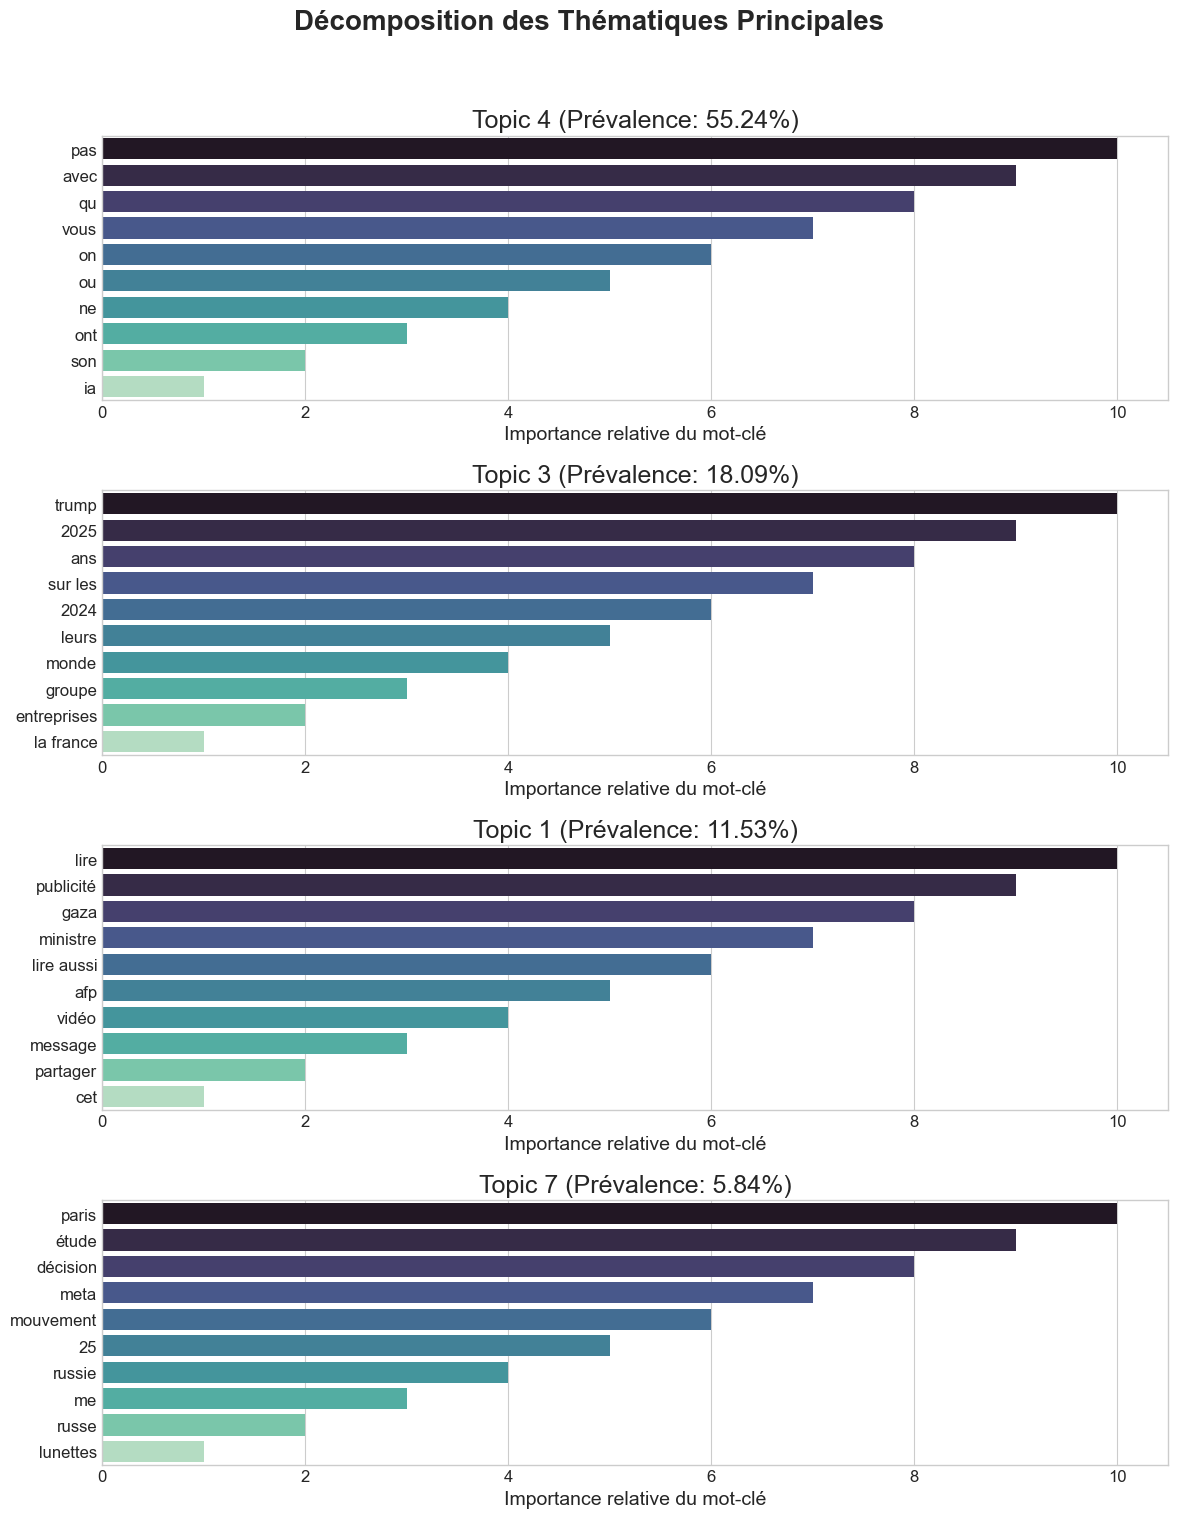


--- Interprétation de l'Analyse Sémantique ---
Cette vue détaillée permet de nommer chaque topic en fonction de ses mots-clés.
Exemple : Un topic contenant 'gouvernement, loi, parlement' peut être nommé 'Politique'.
Action : Vérifier si la couverture thématique correspond aux objectifs stratégiques. Faut-il acquérir plus de données sur des topics sous-représentés ?


In [19]:
if semantic_results:
    print("\n\nLancement de l'analyse détaillée des thématiques...")
    
    # Visualisation des mots clés pour les topics les plus importants
    top_topics_indices = topic_df.head(4).index
    num_top_topics = len(top_topics_indices)
    
    fig, axes = plt.subplots(num_top_topics, 1, figsize=(12, num_top_topics * 4))
    if num_top_topics == 1: # Si un seul topic, axes n'est pas un tableau
        axes = [axes]
        
    fig.suptitle("Décomposition des Thématiques Principales", fontsize=20, fontweight='bold')

    for i, topic_id in enumerate(top_topics_indices):
        topic_info = semantic_results['topics'][topic_id]
        topic_words = topic_info['words']
        # Les poids des mots ne sont pas directement dans LDA, on simule par l'ordre
        word_weights = np.arange(len(topic_words), 0, -1)
        
        sns.barplot(x=word_weights, y=topic_words, ax=axes[i], orient='h', palette='mako')
        prevalence = topic_df.loc[topic_id, 'prevalence']
        axes[i].set_title(f"Topic {topic_id} (Prévalence: {prevalence:.2%})")
        axes[i].set_xlabel('Importance relative du mot-clé')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig(VISUALS_DIR / 'analyse_topics_detailles.png', dpi=300)
    plt.show()

    # --- Interprétation des Thématiques ---
    print("\n--- Interprétation de l'Analyse Sémantique ---")
    print("Cette vue détaillée permet de nommer chaque topic en fonction de ses mots-clés.")
    print("Exemple : Un topic contenant 'gouvernement, loi, parlement' peut être nommé 'Politique'.")
    print("Action : Vérifier si la couverture thématique correspond aux objectifs stratégiques. Faut-il acquérir plus de données sur des topics sous-représentés ?")

else:
    print("\n\nSection d'analyse sémantique sautée (pas de résultats disponibles).")


In [20]:
print("\n--- Résumé Statistique du Corpus ---")
stats_summary = df_quality.describe(include=np.number).round(2)
print(stats_summary[['quality_score_advanced', 'text_complexity', 'readability_score', 'entities_total', 'info_density']])



--- Résumé Statistique du Corpus ---
       quality_score_advanced  text_complexity  readability_score  \
count                  128.00           128.00             128.00   
mean                     0.68             0.98               0.28   
std                      0.06             0.07               0.23   
min                      0.53             0.47               0.00   
25%                      0.64             1.00               0.04   
50%                      0.68             1.00               0.27   
75%                      0.72             1.00               0.44   
max                      0.89             1.00               0.86   

       entities_total  info_density  
count          128.00        128.00  
mean            23.11          4.15  
std             20.27          2.32  
min              1.00          0.29  
25%             11.00          2.32  
50%             19.00          4.06  
75%             28.25          5.51  
max            176.00         12.80 

In [21]:
# --- Insights Actionnables ---
print("\n--- Insights et Recommandations ---")
print("1. QUALITÉ GLOBALE :")
print(f"   Le score de qualité moyen est de {mean_quality:.2f}. Les articles avec un score inférieur à {stats_summary.loc['25%', 'quality_score_advanced']} devraient être examinés ou exclus des corpus d'entraînement de haute qualité.")
print("\n2. GESTION DES SOURCES :")
top_reliable_source = source_analysis.iloc[0]
low_reliable_source = source_analysis.iloc[-1]
print(f"   Prioriser la collecte depuis des sources comme '{top_reliable_source['source'].split('/')[-1]}' (fiabilité: {top_reliable_source['reliability_score']:.2f}).")
print(f"   Surveiller ou réduire la dépendance à des sources comme '{low_reliable_source['source'].split('/')[-1]}' (fiabilité: {low_reliable_source['reliability_score']:.2f}).")



--- Insights et Recommandations ---
1. QUALITÉ GLOBALE :
   Le score de qualité moyen est de 0.68. Les articles avec un score inférieur à 0.64 devraient être examinés ou exclus des corpus d'entraînement de haute qualité.

2. GESTION DES SOURCES :
   Prioriser la collecte depuis des sources comme 'titres.rss' (fiabilité: 0.43).
   Surveiller ou réduire la dépendance à des sources comme 'rss.xml' (fiabilité: 0.30).


In [22]:
if semantic_results:
    dominant_topic_words = topic_df.iloc[0]['words']
    print(f"   Le contenu est actuellement dominé par la thématique '{dominant_topic_words}'. Évaluer si cet alignement est souhaité.")
print("   Les pics d'activité temporelle sont des opportunités pour analyser les tendances et la réactivité des sources.")


   Le contenu est actuellement dominé par la thématique 'pas, avec, qu'. Évaluer si cet alignement est souhaité.
   Les pics d'activité temporelle sont des opportunités pour analyser les tendances et la réactivité des sources.


In [23]:

print("\n4. NETTOYAGE ET ANOMALIES :")
print(f"   Il y a {len(anomalies.get('suspects', []))} articles suspects (courts et sans entités) à vérifier manuellement.")
print(f"   {len(anomalies.get('low_quality', []))} articles de très faible qualité ont été identifiés et pourraient être retirés.")



4. NETTOYAGE ET ANOMALIES :
   Il y a 0 articles suspects (courts et sans entités) à vérifier manuellement.
   12 articles de très faible qualité ont été identifiés et pourraient être retirés.
